In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib notebook

# Reading Data

In [3]:
df = pd.read_csv("./corona.csv")

# Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41580 entries, 0 to 41579
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         41505 non-null  float64
 1   background_diseases         18049 non-null  object 
 2   background_diseases_binary  41580 non-null  int64  
 3   confirmed_date              41580 non-null  object 
 4   date_onset_symptoms         41440 non-null  object 
 5   deceased_date               4948 non-null   object 
 6   severity_illness            5498 non-null   object 
 7   sex                         41580 non-null  object 
 8   smoking                     41310 non-null  float64
 9   treatment                   41580 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.2+ MB


In [5]:
df.head()

,age,background_diseases,background_diseases_binary,confirmed_date,date_onset_symptoms,deceased_date,severity_illness,sex,smoking,treatment
0,62.0,"diabetes,",1,02/06/2020,20/05/2020,NaN,NaN,man,0.0,clinic
1,73.0,NaN,0,07/06/2020,31/05/2020,10/06/2020,deceased,male,0.0,hospitalized
2,47.0,NaN,0,15/04/2020,13/04/2020,NaN,NaN,unknown,0.0,clinic
3,39.0,NaN,0,21/04/2020,17/04/2020,NaN,NaN,male,0.0,clinic
4,47.0,"diabetes,",1,29/04/2020,22/04/2020,12/05/2020,deceased,female,0.0,clinic


In [6]:
df['confirmed_date'] = pd.to_datetime(df['confirmed_date'], dayfirst=True)
df['date_onset_symptoms'] = pd.to_datetime(df['date_onset_symptoms'], dayfirst=True)
df['deceased_date'] = pd.to_datetime(df['deceased_date'], dayfirst=True)


## Age

In [7]:
df['age'].describe()

count    41505.000000
mean        46.100373
std         16.382668
min          0.000000
25%         34.000000
50%         45.000000
75%         57.000000
max        119.000000
Name: age, dtype: float64

(array([2.720e+02, 2.250e+02, 4.390e+02, 1.369e+03, 4.058e+03, 5.336e+03,
        5.695e+03, 5.678e+03, 5.434e+03, 4.487e+03, 3.305e+03, 2.358e+03,
        1.464e+03, 8.380e+02, 3.500e+02, 7.000e+01, 2.000e+01, 2.000e+00,
        0.000e+00, 1.050e+02]),
 array([  0.  ,   5.95,  11.9 ,  17.85,  23.8 ,  29.75,  35.7 ,  41.65,
         47.6 ,  53.55,  59.5 ,  65.45,  71.4 ,  77.35,  83.3 ,  89.25,
         95.2 , 101.15, 107.1 , 113.05, 119.  ]),
 <a list of 20 Patch objects>)

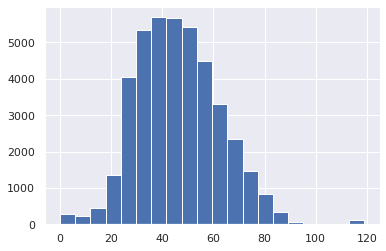

In [8]:
plt.figure()
plt.hist(df['age'].dropna(), bins=20)

In [9]:
df['age'].isna().sum()

75

The most simple way to fill the age missing values is by filling with the median.

(remember that those with the age 119 have no real age)

In [10]:
df['age'] = df['age'].fillna(df['age'].median())

A more complicated way to fill this missing values is using the fact that we know that background diseases and age are highly correlated.
So, we will fill the ages by the median of those with the same background diseases.
(We should remember that a group with some background diseases may contain few people)

In [11]:
df[['background_diseases_binary', 'age']].corr()

,background_diseases_binary,age
background_diseases_binary,1.000000,0.334469
age,0.334469,1.000000


### Binning the age variable.

In [12]:
age_bins = [-1, 9, 19, 29, 39, 49, 59, 69, 79, 89, 120]
age_labels=['0-9', '10-19', '20-29', '30-39', '40-49','50-59', '60-69', '70-79', '80-89', "90+"]

df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels)

## Gender 

In [13]:
df['sex'].value_counts()

female     20684
male       16515
woman       1143
man          961
m            739
F            476
fmale        462
f            213
unknown      167
boy          114
girl         106
Name: sex, dtype: int64

In [14]:
gender_dict = {
    "woman" : "female",
    "man" : "male",
    "m" : "male",
    "F" : "female",
    "f" : "female",
    "fmale" : "female",
    "boy" : "male",
    "girl" : "female"
}

df['sex'].replace(gender_dict, inplace=True)

In [15]:
df['sex'].value_counts()

female     23084
male       18329
unknown      167
Name: sex, dtype: int64

## Smoking

In [16]:
df['smoking'].value_counts()

0.0    37910
1.0     3400
Name: smoking, dtype: int64

In [17]:
df['smoking'].isna().sum()

270

Checking smoking and gender.

We believe that male and female have different smoking habbits.

Text(0, 0.5, 'percentage')

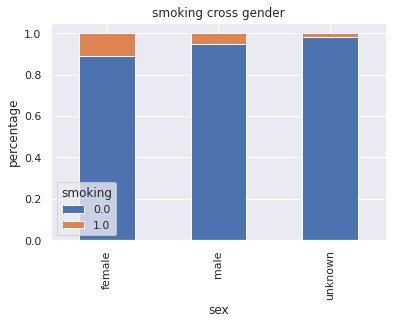

In [18]:
df.groupby(['sex'])['smoking'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True)
plt.title("smoking cross gender")
plt.ylabel("percentage")

It is also required to check the smoking variable against the age group since from previous knowledge we know that diferent age groups have different smoking habbits.

The simplest way in this case is to fill the missing values with 0, since most of the people do not smoke.

In [19]:
df['smoking'] = df['smoking'].fillna(0)

## Background Diseases

In [20]:
df['background_diseases_binary'].value_counts()

0    23501
1    18079
Name: background_diseases_binary, dtype: int64

In [21]:
df['background_diseases'].isna().sum()

23531

We can see that those without background diseases and their binary variable 'background_diseases_binary' do not correspond to each other,
we have to find out why.

Let's check those without background diseases but with binary variable positive and those with background diseases but with binary variable negative:

In [22]:
print("No. of mistakes (has diseases but binary false): %d \n" 
      %len(df[(~df['background_diseases'].isna()) & (df['background_diseases_binary']==0)]))

df[(~df['background_diseases'].isna()) & (df['background_diseases_binary']==0)].head()


No. of mistakes (has diseases but binary false): 113 



,age,background_diseases,background_diseases_binary,confirmed_date,date_onset_symptoms,deceased_date,severity_illness,sex,smoking,treatment,age_group
10,43.0,"hypertension,",0,2020-05-11,2020-05-08,NaT,NaN,female,0.0,clinic,40-49
121,34.0,"asthma,",0,2020-04-30,2020-04-27,NaT,NaN,male,0.0,clinic,30-39
197,65.0,"obesity,",0,2020-04-13,2020-04-13,2020-04-20,critical,male,0.0,hospitalized,60-69
281,64.0,"diabetes, hypertension,",0,2020-04-29,2020-04-15,2020-04-30,deceased,female,0.0,hospitalized,60-69
1337,59.0,"diabetes, hypertension, obesity,",0,2020-05-02,2020-04-29,NaT,NaN,male,0.0,clinic,50-59


In [23]:
print("No. of mistakes (no diseases but binary true): %d \n" 
      %len(df[(df['background_diseases'].isna()) & (df['background_diseases_binary']==1)]))

df[(df['background_diseases'].isna()) & (df['background_diseases_binary']==1)].head()


No. of mistakes (no diseases but binary true): 143 



,age,background_diseases,background_diseases_binary,confirmed_date,date_onset_symptoms,deceased_date,severity_illness,sex,smoking,treatment,age_group
345,55.0,NaN,1,2020-04-22,2020-04-16,NaT,NaN,female,0.0,hospitalized,50-59
530,27.0,NaN,1,2020-06-01,2020-05-31,NaT,NaN,male,0.0,clinic,20-29
543,42.0,NaN,1,2020-04-13,2020-04-11,NaT,NaN,male,0.0,clinic,40-49
948,37.0,NaN,1,2020-04-13,2020-04-03,NaT,NaN,male,0.0,clinic,30-39
1013,24.0,NaN,1,2020-05-04,2020-04-17,NaT,NaN,male,0.0,clinic,20-29


We see that the binary variable is incorrect.

It is given that the most reliable feature is 'background_diseases', so we will recreate 'background_diseases_binary' by ourselves.

In [24]:
df['background_diseases_binary'] = 1- df['background_diseases'].isna()

Now, lets see all the possible background diseases.

In [25]:
df['background_diseases'].value_counts()

 obesity,                                                                           4458
 hypertension,                                                                      2731
 diabetes,                                                                          2340
 diabetes, hypertension,                                                            1857
 hypertension, obesity,                                                             1241
                                                                                    ... 
 asthma, immunosuppression, hypertension, obesity, kidney failure,                     1
 immunosuppression, hypertension, cardiovascular, kidney failure,                      1
 chronic obstructive pulmonary, asthma, kidney failure,                                1
 chronic obstructive pulmonary, immunosuppression, kidney failure,                     1
 chronic obstructive pulmonary, immunosuppression, hypertension, kidney failure,       1
Name: background_dise

In [26]:
np.unique("".join(df['background_diseases'].dropna().to_list()).split(","))

array(['', ' asthma', ' cardiovascular', ' chronic obstructive pulmonary',
       ' diabetes', ' hypertension', ' immunosuppression',
       ' kidney failure', ' obesity'], dtype='<U30')

OK.
Now, we will find for each patient his background diseases, and merge it with the origin dataframe.

In [27]:
diseases_df = df['background_diseases'].str.replace(' ','').str.get_dummies(sep=',')

In [28]:
df = pd.merge(df, diseases_df, left_index=True, right_index=True)
df = df.drop("background_diseases", axis=1)

Checking the connection between all the backgrounf sideases.

We will check the correlation between them.

In [60]:
background_diseases = ['asthma', 'cardiovascular','chronicobstructivepulmonary', 'diabetes',
                       'hypertension', 'immunosuppression', 'kidneyfailure', 'obesity', 'age']

Text(0.5, 1.0, 'Background Diseases Correlation')

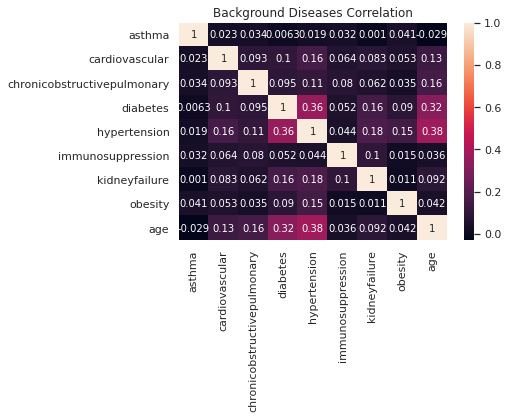

In [61]:
plt.figure()

background_diseases_corr = sns.heatmap(df[background_diseases].corr(), annot=True)
background_diseases_corr.set_title("Background Diseases Correlation")

## Dates

In [30]:
df[["confirmed_date", "date_onset_symptoms", "deceased_date"]].describe()

,confirmed_date,date_onset_symptoms,deceased_date
count,41580,41440,4948
unique,139,144,82
top,2020-06-01 00:00:00,2020-05-25 00:00:00,2020-05-17 00:00:00
freq,1393,1299,130
first,2019-03-29 00:00:00,2019-04-08 00:00:00,2020-03-22 00:00:00
last,2020-06-12 00:00:00,2020-06-12 00:00:00,2020-06-12 00:00:00


There are impossible confirmed dates in 2019.

They should be in 2020.

In [31]:
print("No. of confirmed patients before 1.1.20: %d" %sum(df["date_onset_symptoms"] < "2020-01-01"))

No. of confirmed patients before 1.1.20: 53


In [32]:
print("No. of confirmed patients before 1.1.20: %d" %sum(df["confirmed_date"] < "2020-01-01"))

No. of confirmed patients before 1.1.20: 65


In [33]:
df.loc[df["date_onset_symptoms"] < "2020-01-01", "date_onset_symptoms"] = df["date_onset_symptoms"] + pd.offsets.DateOffset(years=1)
df.loc[df["confirmed_date"] < "2020-01-01", "confirmed_date"] = df["confirmed_date"] + pd.offsets.DateOffset(years=1)

In [34]:
print("No. of patients who confirmed before they had symptoms %d" %sum(df["date_onset_symptoms"] > df["confirmed_date"]))

No. of patients who confirmed before they had symptoms 6


In [35]:
print("No. of patients who died before they were confirmed: %d" %sum(df["deceased_date"] < df["confirmed_date"]))

No. of patients who died before they were confirmed: 22


In [36]:
print("No. of deaths according to the death date: %d" %(len(df) - df['deceased_date'].isna().sum()))

No. of deaths according to the death date: 4948


In [37]:
df[~df['deceased_date'].isna()]['severity_illness'].value_counts()

deceased    4242
critical     657
Name: severity_illness, dtype: int64

In [38]:
df[~df['deceased_date'].isna()]['severity_illness'].isna().sum()

49

We see that not all the patients who have death date, are written as dead.

According to the supervisor, we have to treat them as dead.

In [39]:
df.loc[~df['deceased_date'].isna(), 'severity_illness'] = "deceased"

## Severity illness

In [40]:
df['severity_illness'].value_counts()

deceased    4948
critical     599
Name: severity_illness, dtype: int64

In [41]:
df['severity_illness'].isna().sum()

36033

In order to make our life easier, we will fill the missing values as follows:

In [42]:
df['severity_illness'] = df['severity_illness'].fillna("slight")

At first, lets check the effect of background diseases on patients' illness.

In [43]:
df.pivot_table(values="background_diseases_binary", index="severity_illness")

,background_diseases_binary
severity_illness,
critical,0.585977
deceased,0.702910
slight,0.394638


We can see that on average most of those who died or got critically illed have background diseases.


Now, we have to check if it depends on the disease.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Automatic legend placement (loc='best') not implemented for figure legend. Falling back on 'upper right'. This will raise an exception in 3.3.
  import sys


Text(0.5, 0.98, 'severity of illness cross background diseases')

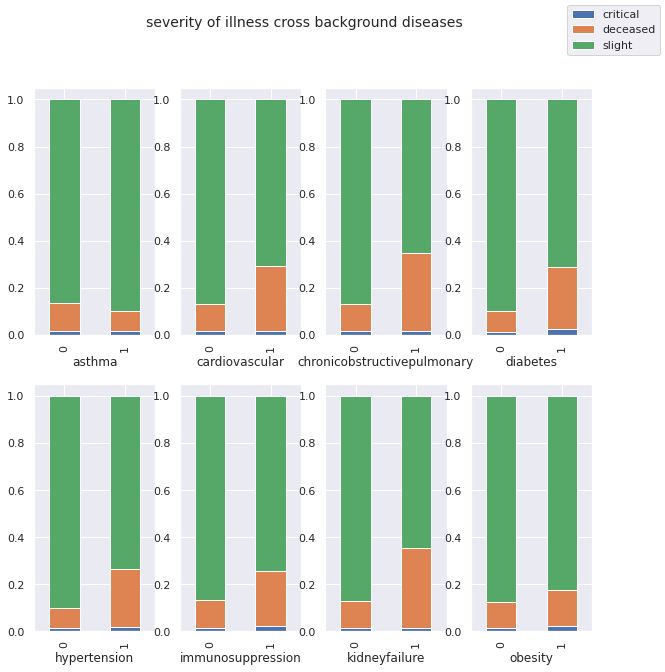

In [100]:
fig, axes = plt.subplots(2,4, figsize=(10,10))

for i, ax in zip(range(len(background_diseases)), axes.flat):
   df.groupby([background_diseases[i]])['severity_illness'].value_counts(normalize=True).unstack().plot(kind='bar', stacked=True, ax=ax, legend=False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='best')
fig.suptitle("severity of illness cross background diseases", size=14)



Pay attention that in this point you should be reminded in the correlation matrix between the diseases we have seen before. 

why?


Text(0.5, 1.0, 'Distribution of severity of illnes by age')

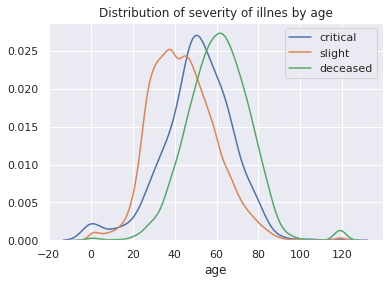

In [44]:
sns.distplot(df[df['severity_illness']=="critical"]['age'], hist=False, label="critical")
sns.distplot(df[df['severity_illness']=="slight"]['age'], hist=False, label="slight")
sns.distplot(df[df['severity_illness']=="deceased"]['age'], hist=False, label="deceased")
plt.title("Distribution of severity of illnes by age")

severity_illness  critical  deceased    slight
sex                                           
female            0.017155  0.142523  0.840322
male              0.010966  0.089858  0.899176
unknown           0.011976  0.065868  0.922156


Text(0, 0.5, 'percentage')

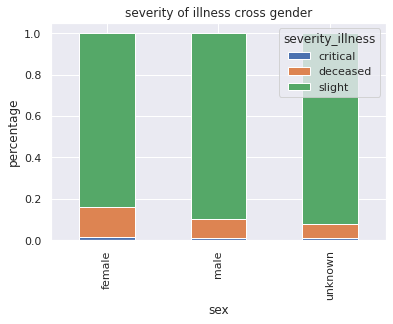

In [51]:
sex_cross_severity = df.groupby(['sex'])['severity_illness'].value_counts(normalize=True).unstack()
sex_cross_severity.plot(kind='bar', stacked=True)
print(sex_cross_severity)
plt.title("severity of illness cross gender")
plt.ylabel("percentage")

severity_illness  critical  deceased    slight
smoking                                       
0.0               0.014432  0.117679  0.867889
1.0               0.014118  0.133824  0.852059


Text(0, 0.5, 'percentage')

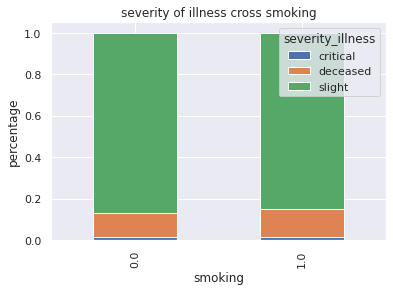

In [50]:
smoking_cross_severity = df.groupby(['smoking'])['severity_illness'].value_counts(normalize=True).unstack()
smoking_cross_severity.plot(kind='bar', stacked=True)
print(smoking_cross_severity)
plt.title("severity of illness cross smoking")
plt.ylabel("percentage")